In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import ssts.segmentation.segmentation_gmm as seg_gmm
import ssts.segmentation.segmentation_watershed as seg_water
from ssts.utils import pre_processing as pre
from ssts.utils import post_processing as post
from ssts.utils import seg_label_utils as slu
from ssts.utils import config


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
fill_zeros_flag = True
remove_outliers_flag = True
input_cmap = "jet"

In [21]:
# 2 component data
data_file = "/Users/diegotorrejon/Projects/Other/SSTS/data/2componentfilms/combined/PTB7PC71BM_CBonly_ascast_fresh_500_nm_combined.npy"
data_type = "QNM"
data_subtype = "2ComponentFilms"

# cAFM data
data_file = "/Users/diegotorrejon/Dropbox/SSTS_files/Manuscript/data_files/WT2-97_cafm.npy"
data_type = "cAFM"
data_subtype = None

# Paper data (cafm)
data_file = "/Users/diegotorrejon/Dropbox/SSTS_files/Manuscript/data_files/WT2-97_cAFM0003.npy"
data_type = "cAFM"
data_subtype = None


# Paper data (amfm)
#data_file = "/Users/diegotorrejon/Dropbox/SSTS_files/Manuscript/data_files/WT2-107_amfm_90.npy"
#data_type = "AMFM"
#data_subtype = None

# nanowires data
#data_file = "/Users/diegotorrejon/Projects/Other/SSTS/data/nanowires/combined/100-0_48_NW_combined.npy" 
#data_type = "QNM"
#data_subtype = "Nanowires"

# Paper data (nanowires)
data_file = "/Users/diegotorrejon/Dropbox/SSTS_files/Manuscript/data_files/100-0_72_NW_combined.npy"
data_type = "QNM"
data_subtype = "Nanowires"

# Paper data (opv)
data_file = "/Users/diegotorrejon/Dropbox/SSTS_files/Manuscript/data_files/175C_30min_Sub8_Dev8.npy"
data_type = "QNM"
data_subtype = "Nanowires"

# Paper data (opv)
data_file = "/Users/diegotorrejon/Projects/Other/SSTS/data/100C_5min_Sub1_Dev4.npy"
data_type = "QNM"
data_subtype = None

data = np.load(data_file)

data_properties = config.data_info[data_type]['properties']


['Adhesion', 'Deformation', 'LogDMT', 'Height', 'Stiffness']


/Users/diegotorrejon/Projects/Other/SSTS/VENV/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/diegotorrejon/Projects/Other/SSTS/VENV/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


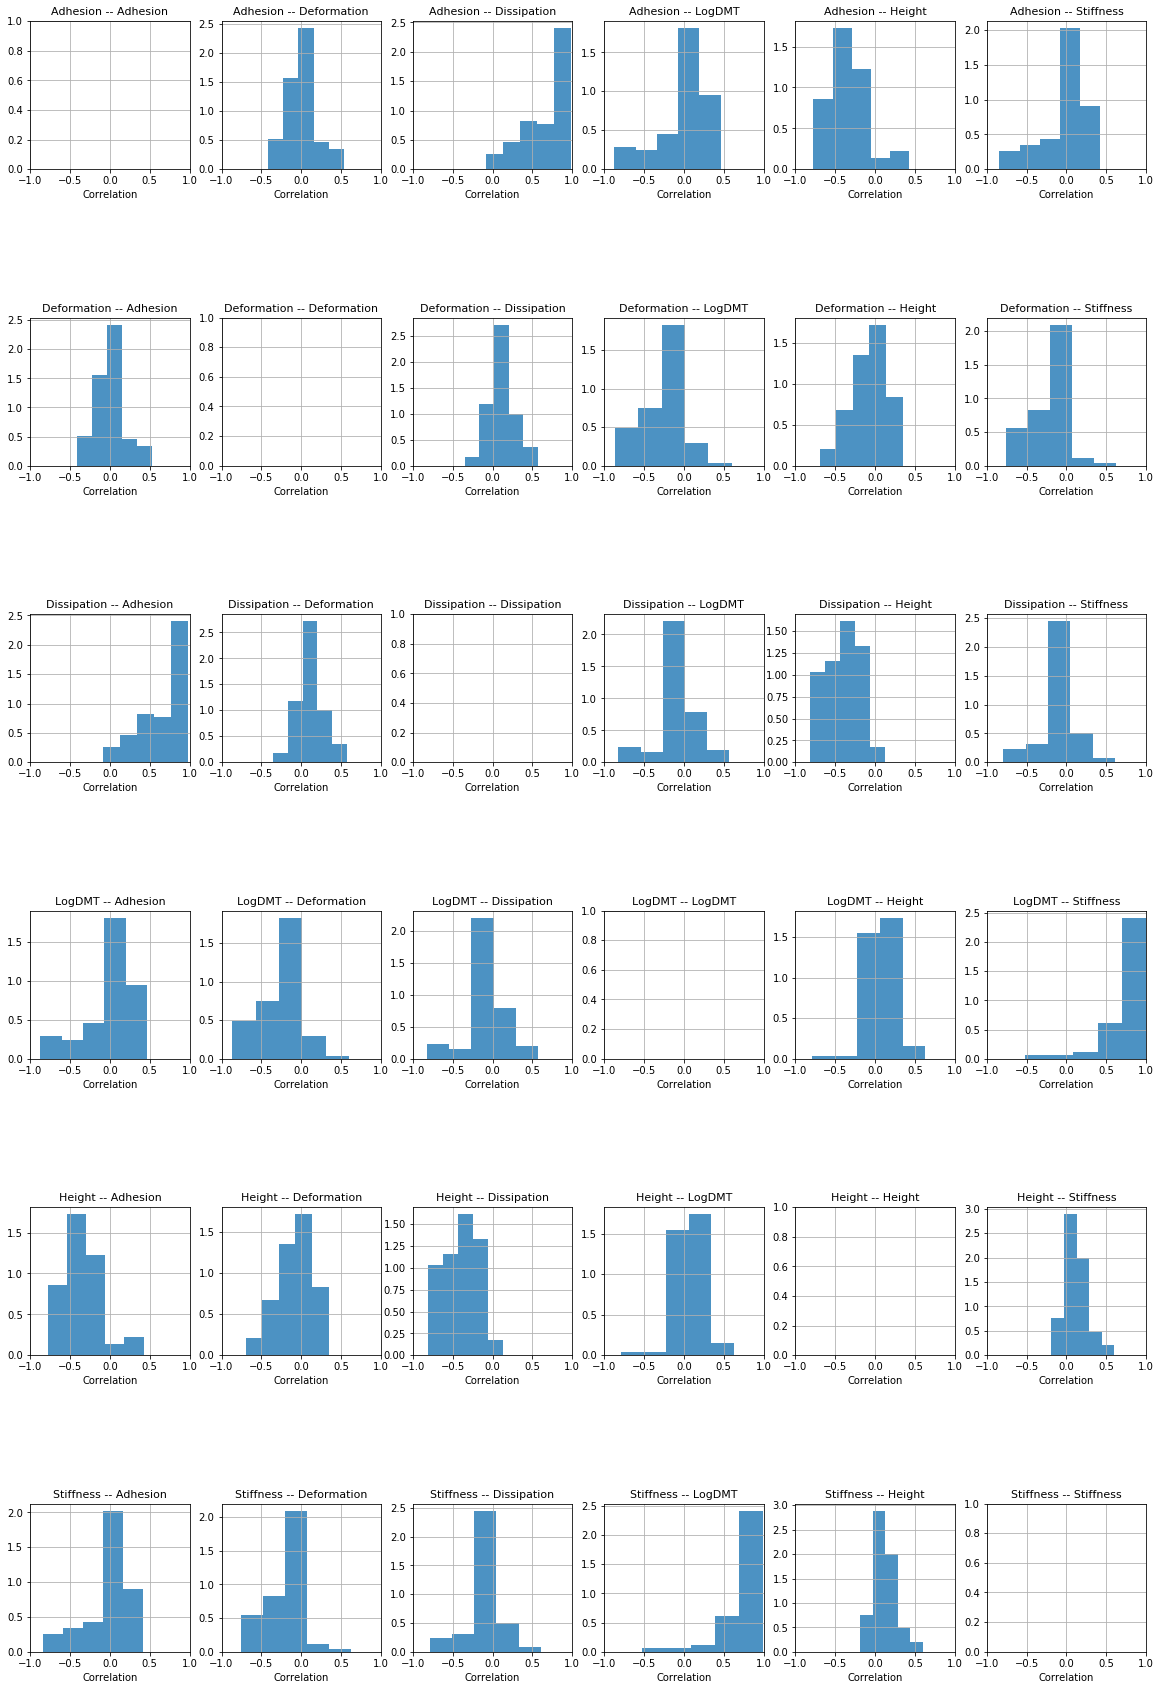

In [77]:
# NOTE: I picked backgrounded because it has the most data files
data_dir = "/Users/diegotorrejon/Dropbox/SSTS_files/AFM/QNM/Backgrounded/Combined/"
pre.show_correlations(data.shape[2], "QNM", data_dir)


IndexError: list index out of range

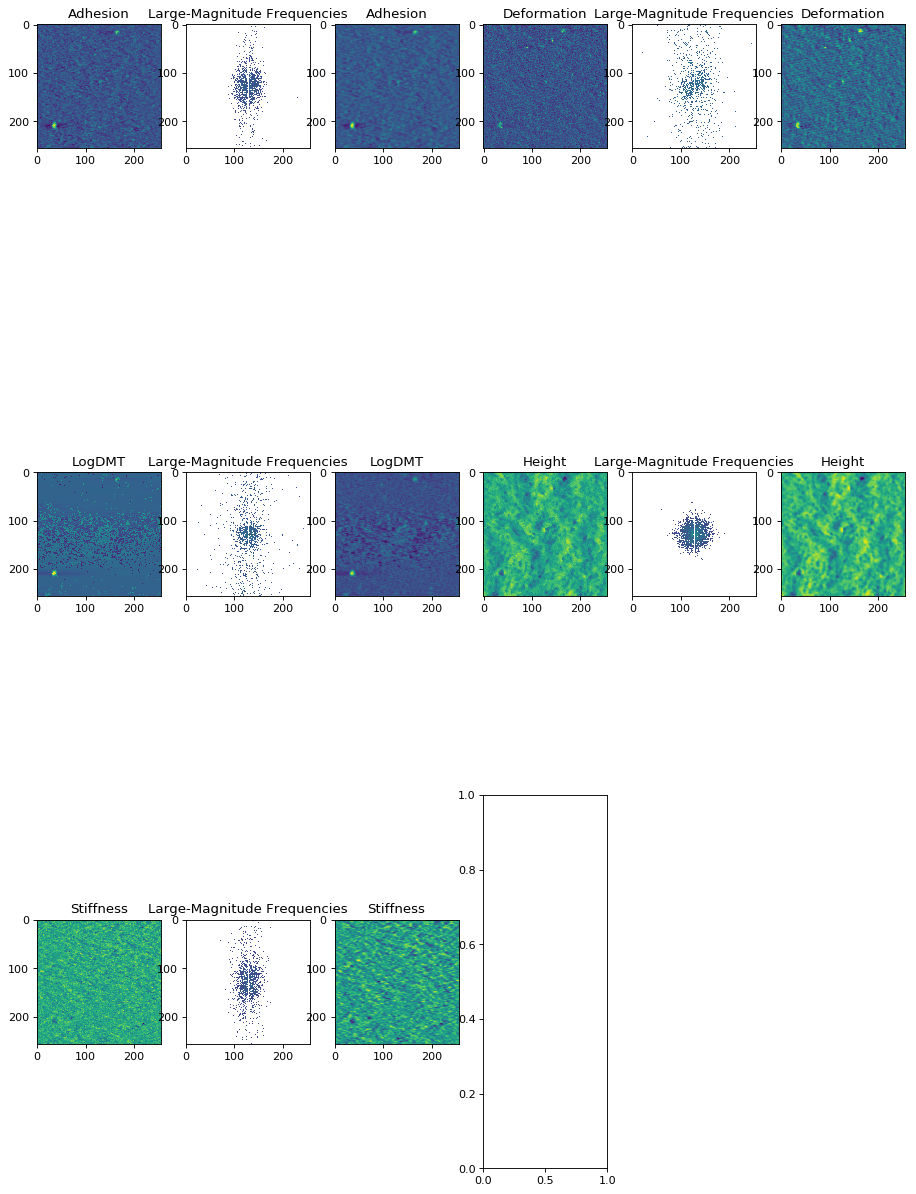

In [15]:
# Apply high pass filter
filtered_data = pre.apply_frequency_removal(data, data_type)


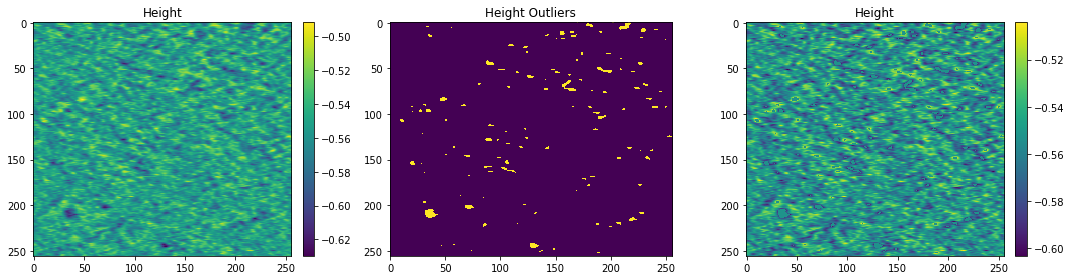

In [6]:
# Get (z-score) outliers
outliers = pre.extract_outliers(filtered_data, data_type)
pre.show_outliers(filtered_data, data_type, outliers)

no_outliers_data = pre.smooth_outliers_from_data(filtered_data, outliers)


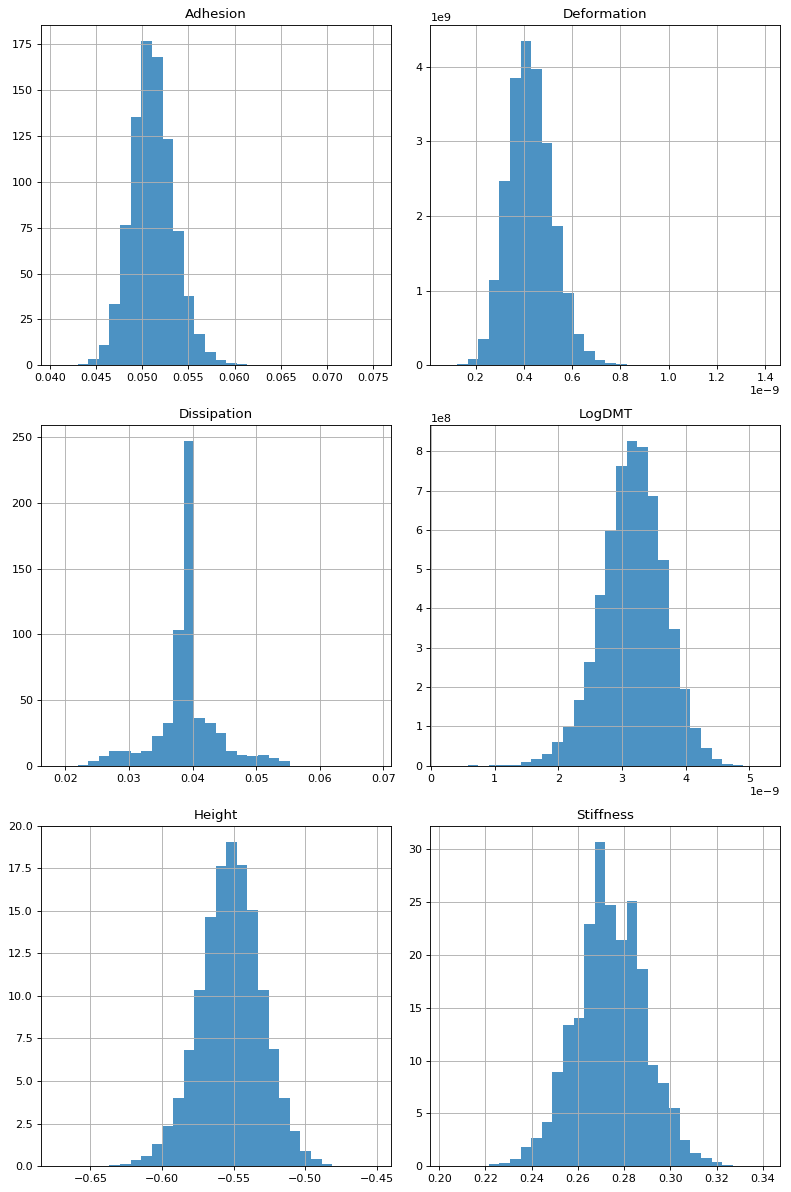

In [7]:
# Show a-priori property distributions
if remove_outliers_flag:
    pre.show_property_distributions(data, data_type, outliers)
else:
    pre.show_property_distributions(data, data_type)
    

In [ ]:
# Remove bad property distributions
c = data.shape[2]
buckets = 100 # TODO optimize
remove_channels = []
for i in range(c):
    channel = data[:,:,i].flatten()
    counts, bins = np.histogram(channel, buckets)
    norm_counts = counts / sum(counts) * 100
    max_id, max_count = max(zip(range(buckets), norm_counts), key = lambda k: k[1])
    
    right_diff = max_count - norm_counts[min(max_id + 1, buckets - 1)]
    left_diff = max_count - norm_counts[max(max_id - 1, 0)]
    max_diff = max(right_diff, left_diff)
    if max_diff > 10: # TODO optimize
        print(f"Adding channel to be removed: {data_properties[i]}")
        remove_channels.append(i)
        
# Remove bad channels
for i in remove_channels[::-1]:
    no_outliers_data = np.delete(no_outliers_data, i, axis=2)
    del data_properties[i]


In [8]:
# Apply semantic segmentation (GMM)
c = data.shape[2]
num_pca_components = min(4, c)
seg = seg_gmm.SegmenterGMM(n_components=2, embedding_dim=num_pca_components,
                           nonlinear=True, normalize=True,
                          padding=0, zscale=False)
    
if remove_outliers_flag:
    pre_labels = seg.fit_transform(no_outliers_data, outliers)
else:
    pre_labels = seg.fit_transform(data)


In [9]:
if fill_zeros_flag:
    pre_labels = slu.fill_out_zeros(pre_labels, outliers)
elif remove_outliers_flag:
    pre_labels = np.ma.masked_where(outliers == 1, pre_labels)
    

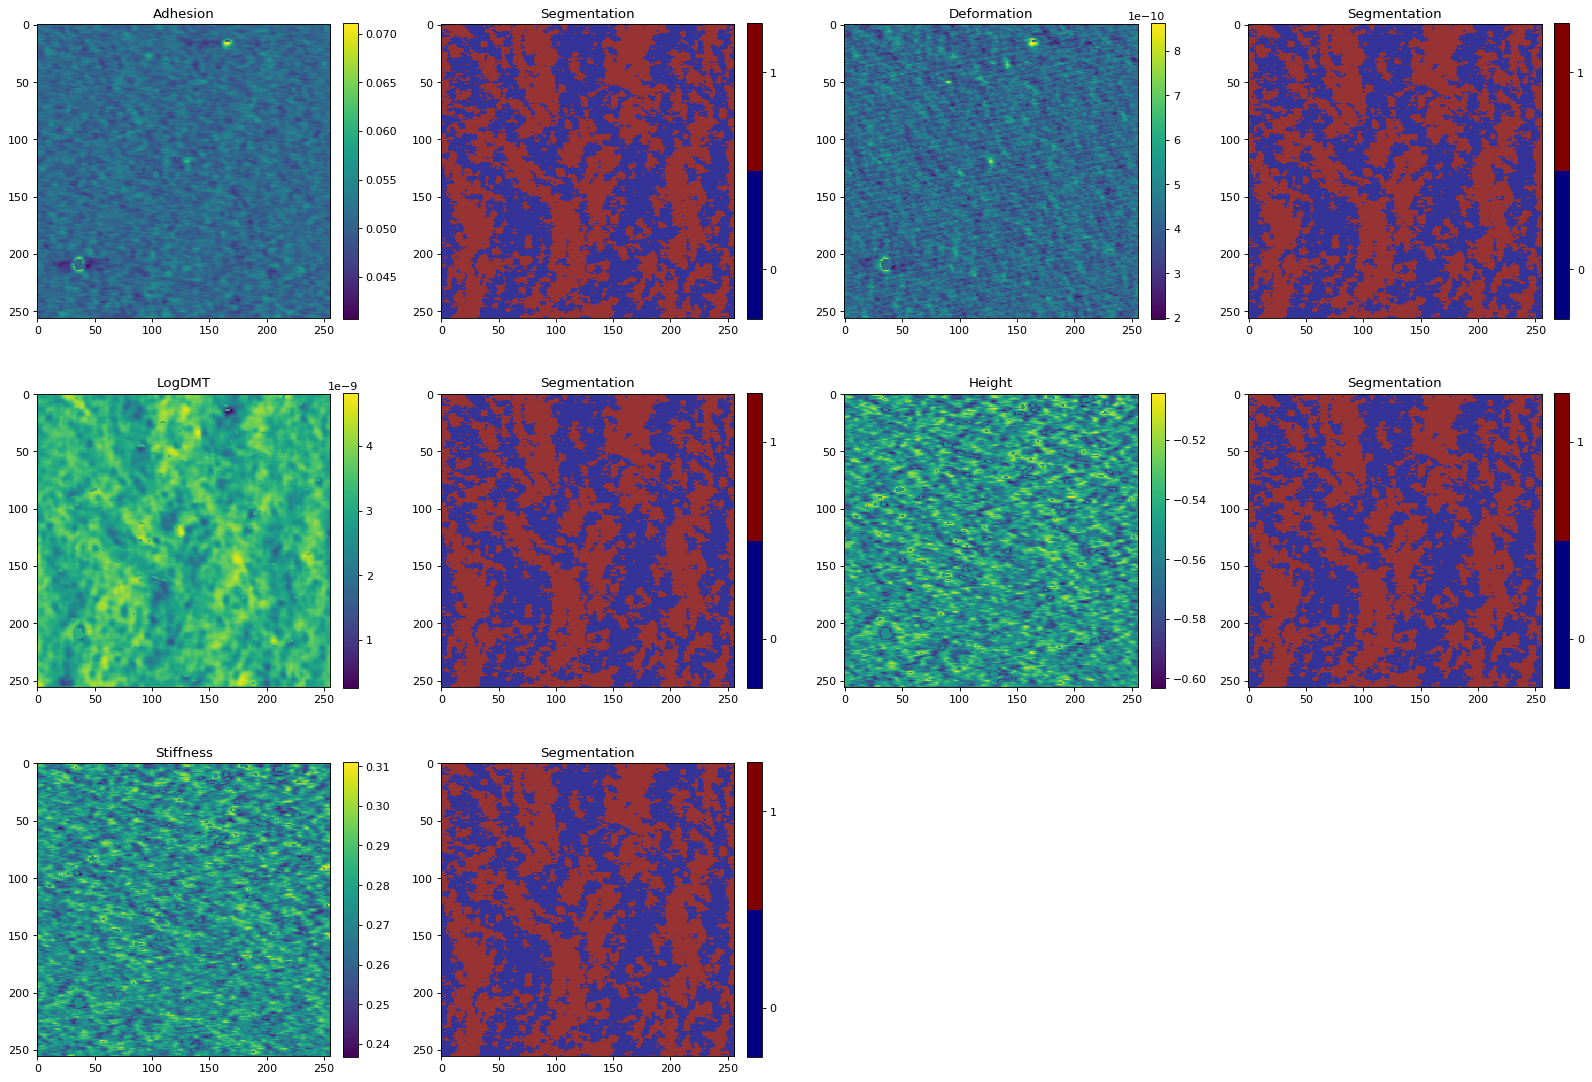

In [10]:
# Semantic segmentation of properties
if remove_outliers_flag:
    post.show_classification(pre_labels, no_outliers_data, data_type)
else:
    post.show_classification(pre_labels, data, data_type)
    

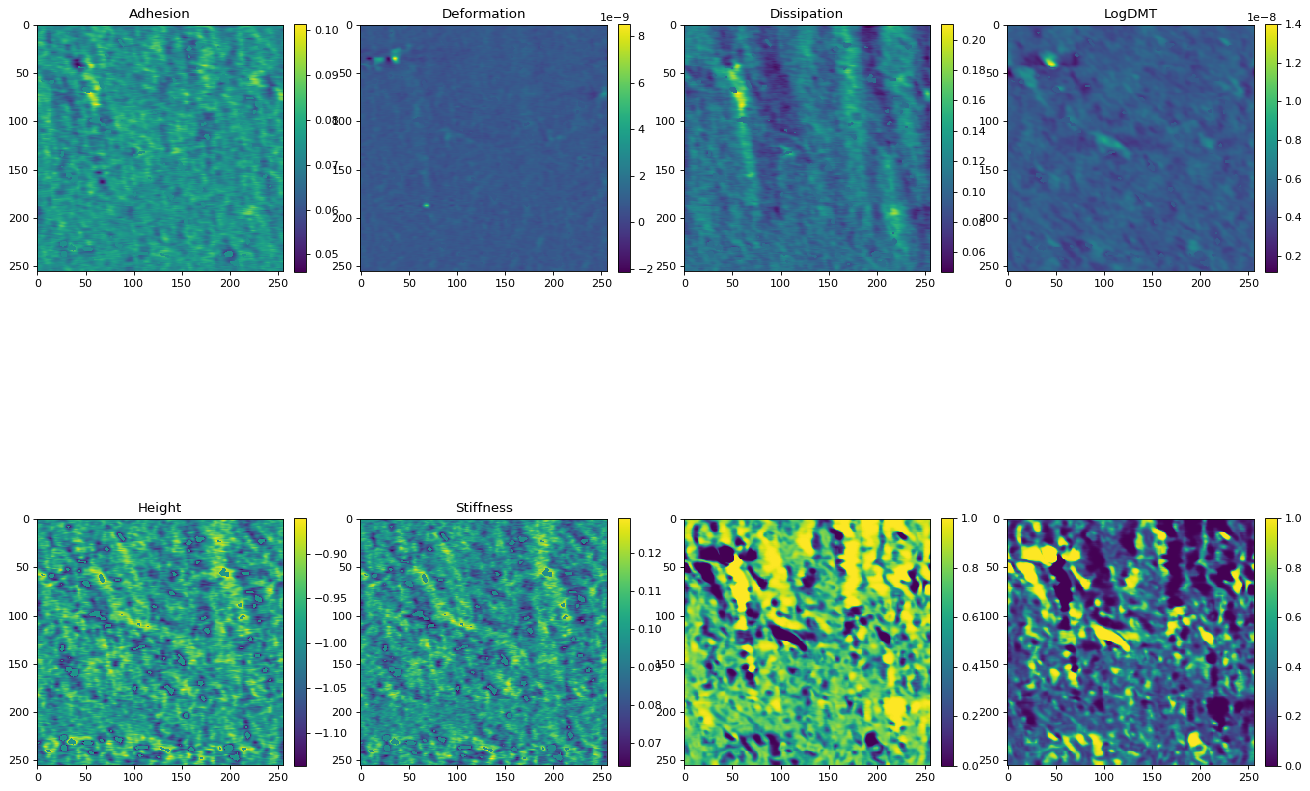

In [32]:
# Semantic segmentation likelihood of properties
if remove_outliers_flag:
    probs = seg.get_probabilities(no_outliers_data)
    post.show_overlaid_distribution(probs, no_outliers_data, data_type, outliers)
else:
    probs = seg.get_probabilities(data)
    post.show_overlaid_distribution(probs, data, data_type)


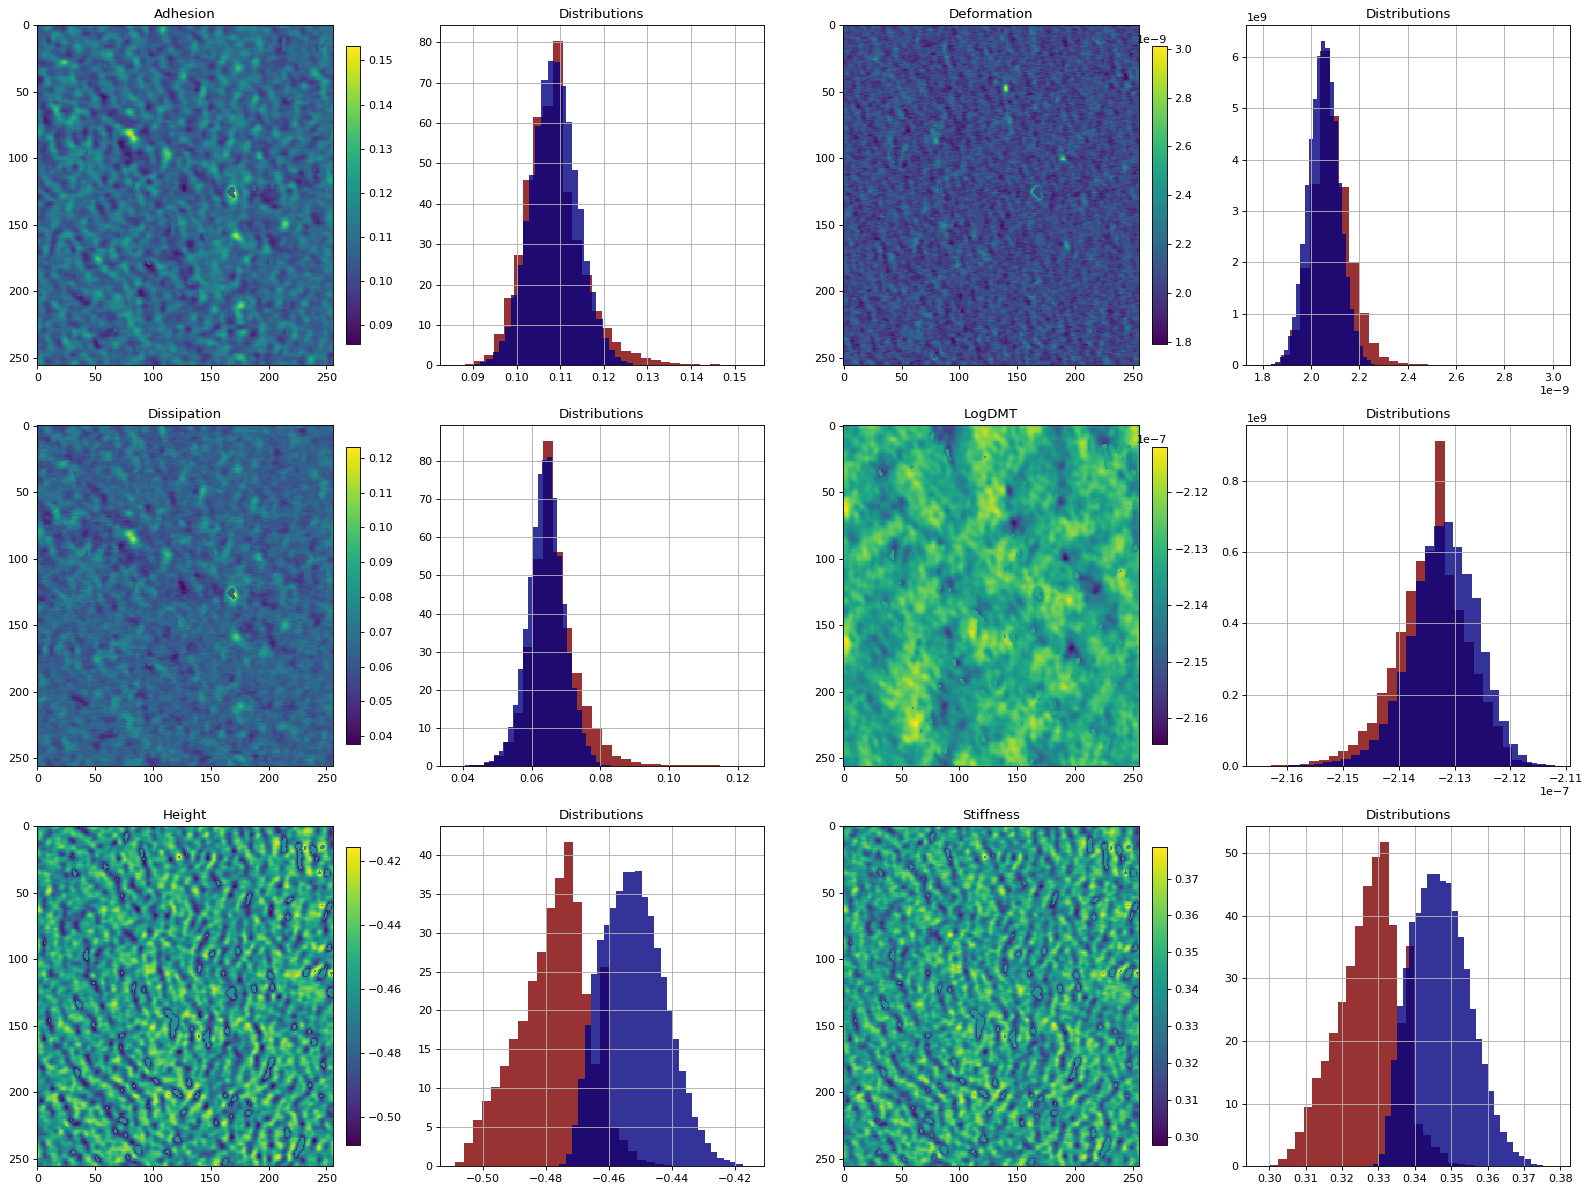

In [65]:
# Distributions of properties after semantic segmentation
if remove_outliers_flag:
    post.show_classification_distributions(pre_labels, no_outliers_data, data_type)
else:
    post.show_classification_distributions(pre_labels, data, data_type)
    

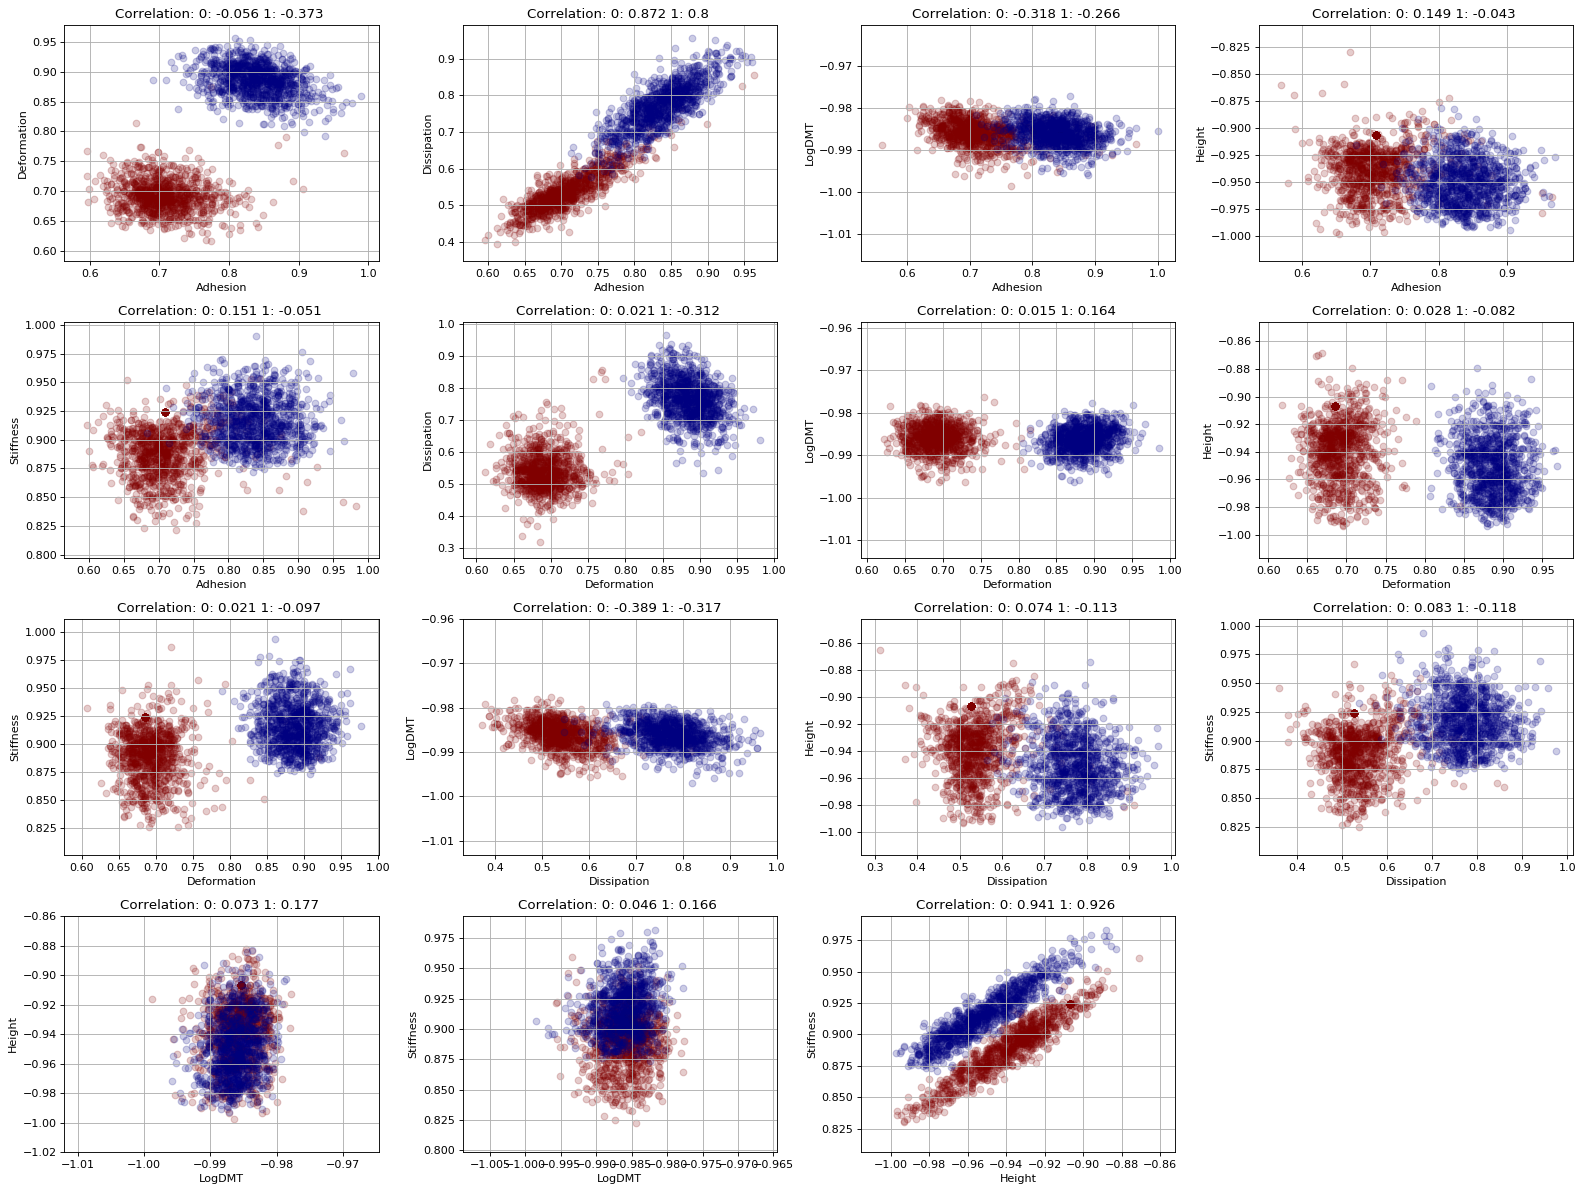

In [66]:
# Scatter plot and correlation of properties after semantic segmentation
if remove_outliers_flag:
    post.show_classification_correlation(pre_labels, no_outliers_data, data_type)
else:
    post.show_classification_correlation(pre_labels, data, data_type)
    

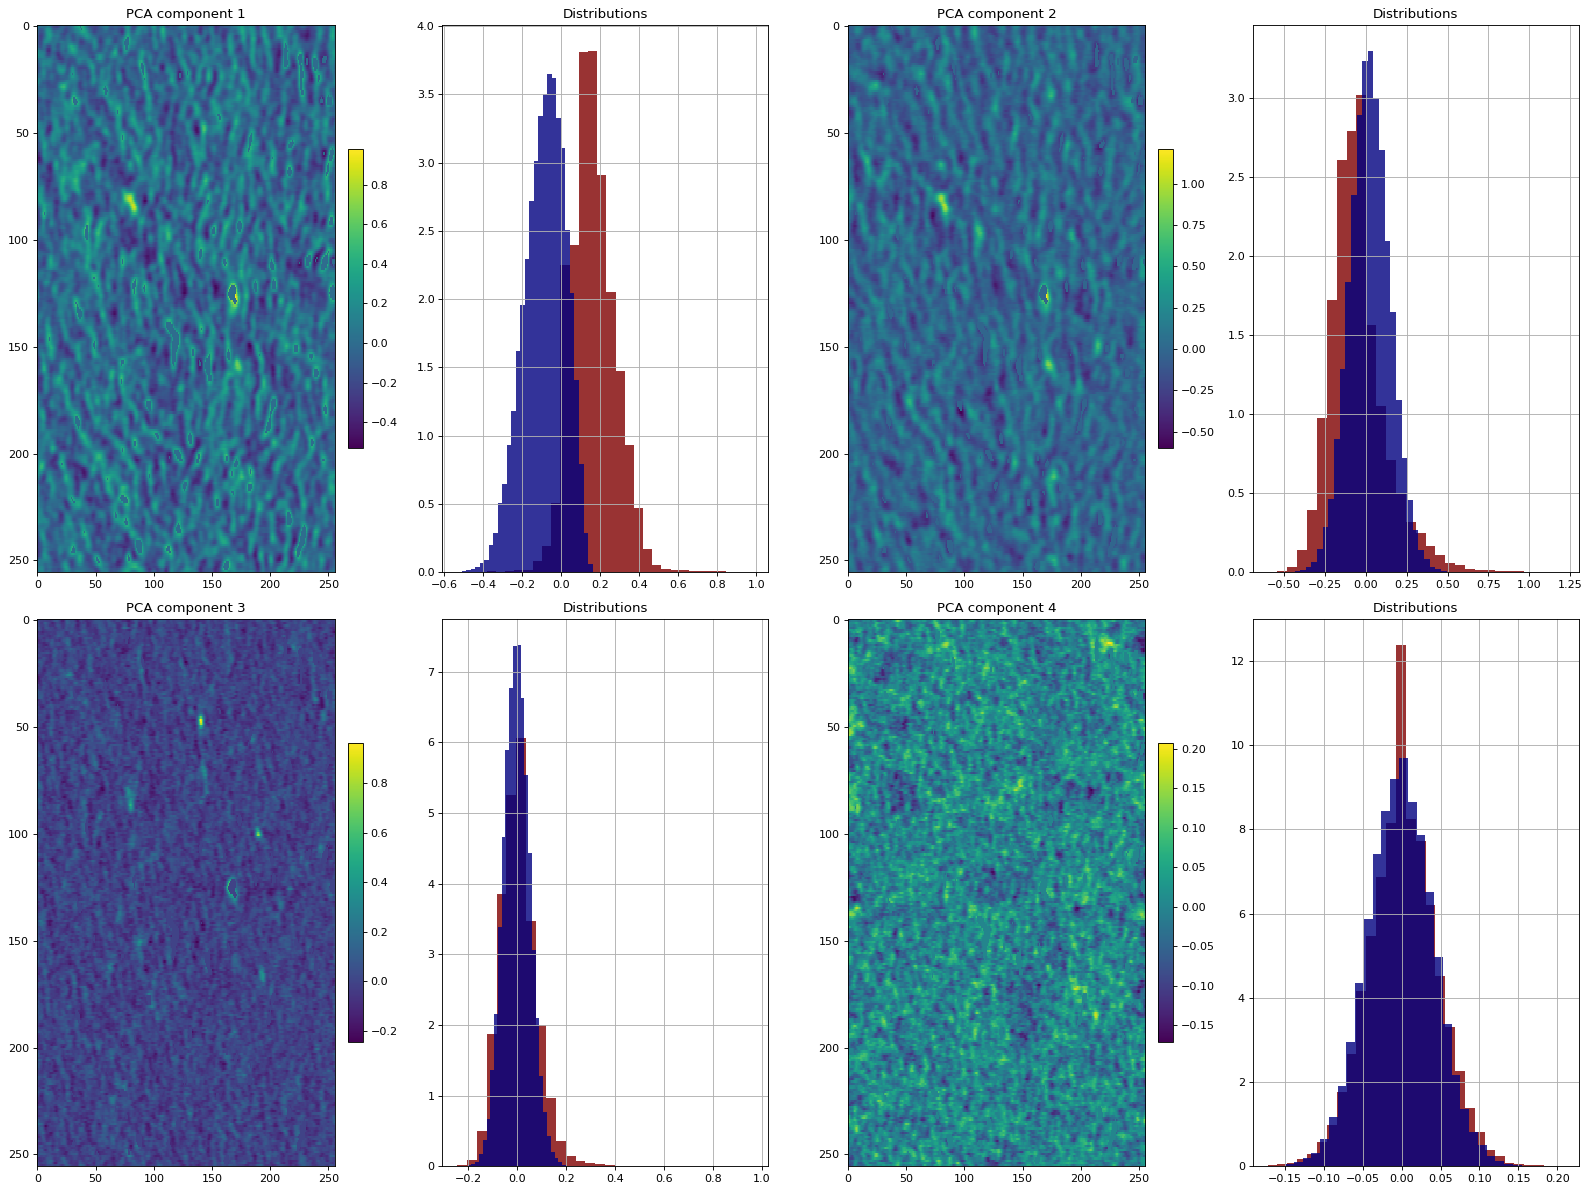

In [67]:
# Distributions of PCA components after semantic segmentation
if remove_outliers_flag:
    pca_components = seg.get_pca_components(no_outliers_data)
else:
    pca_components = seg.get_pca_components(data)

h, w, c = data.shape
pca_components = pca_components.reshape(h, w, num_pca_components)

post.show_classification_distributions(pre_labels, pca_components, data_type, title_flag=False)


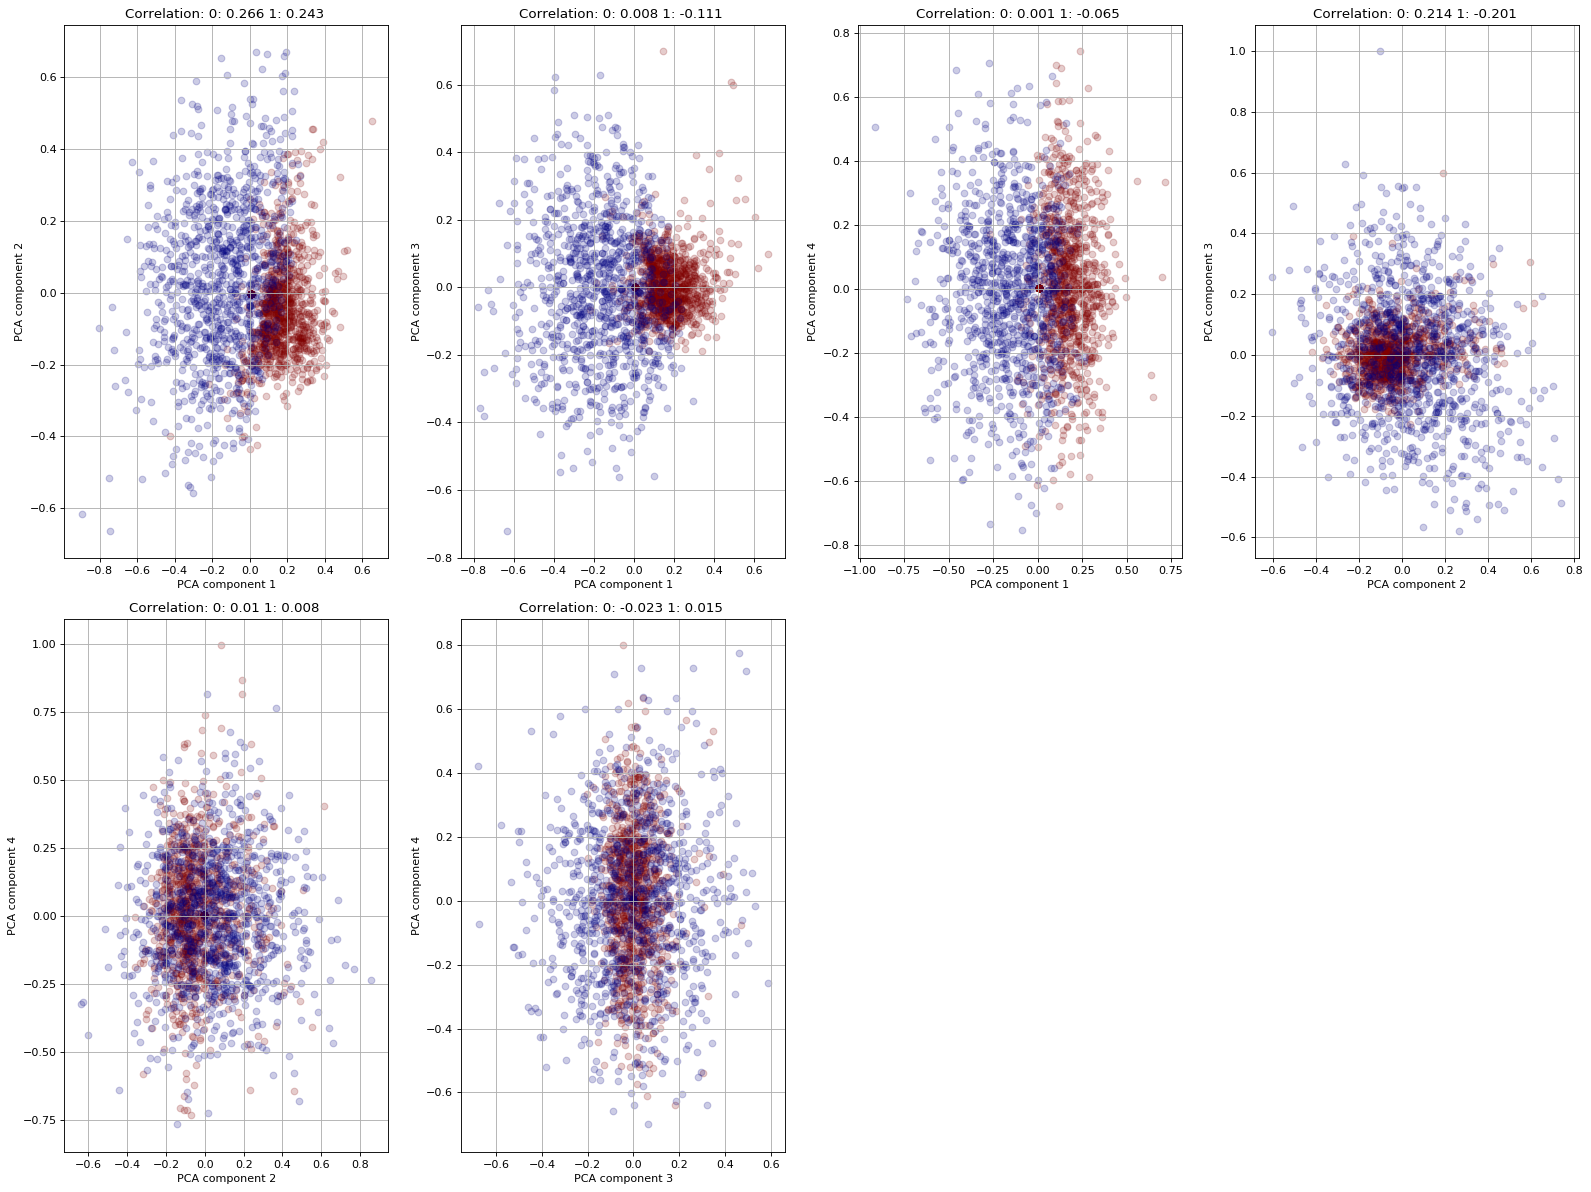

In [68]:
# Scatter plot and correlation of PCA components after semantic segmentation
post.show_classification_correlation(pre_labels, pca_components, data_type, title_flag=False)


In [69]:
# Apply instance segmentation (connected components)
post_labels = seg.get_grains(pre_labels)
grain_labels = slu.get_significant_labels(post_labels, bg_contrast_flag=True)


In [70]:
if fill_zeros_flag:
    grain_labels = slu.fill_out_zeros(grain_labels, grain_labels == 0)
elif remove_outliers_flag:
    grain_labels = np.ma.masked_where(grain_labels == 0, grain_labels)


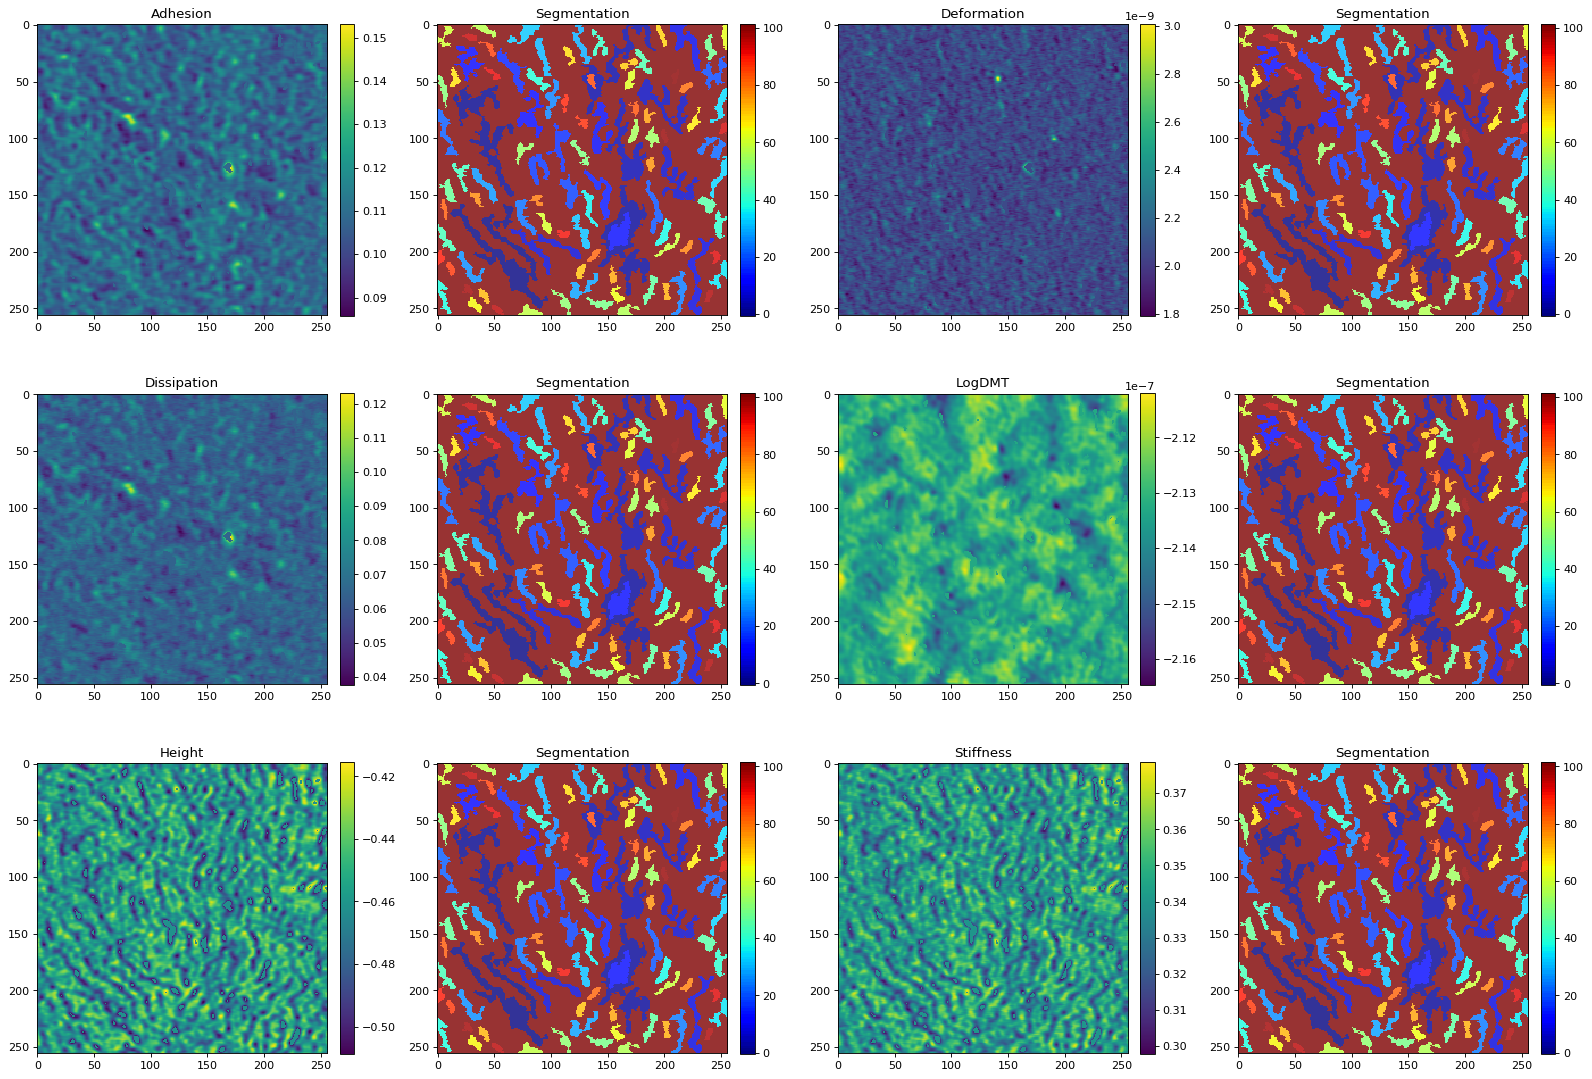

In [71]:
# Instance (grains) segmentation of properties
if remove_outliers_flag:
    post.show_classification(grain_labels, no_outliers_data, data_type, input_cmap=input_cmap)
else:
    post.show_classification(grain_labels, data, data_type, input_cmap=input_cmap)
    

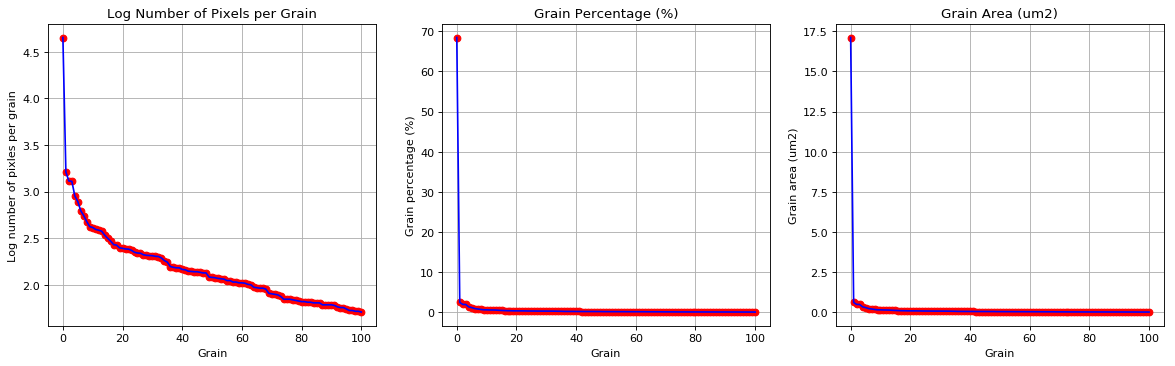

In [72]:
# Show grain area distribution after instance segmentation
post.show_grain_area_distribution(grain_labels, data_type, data_subtype)


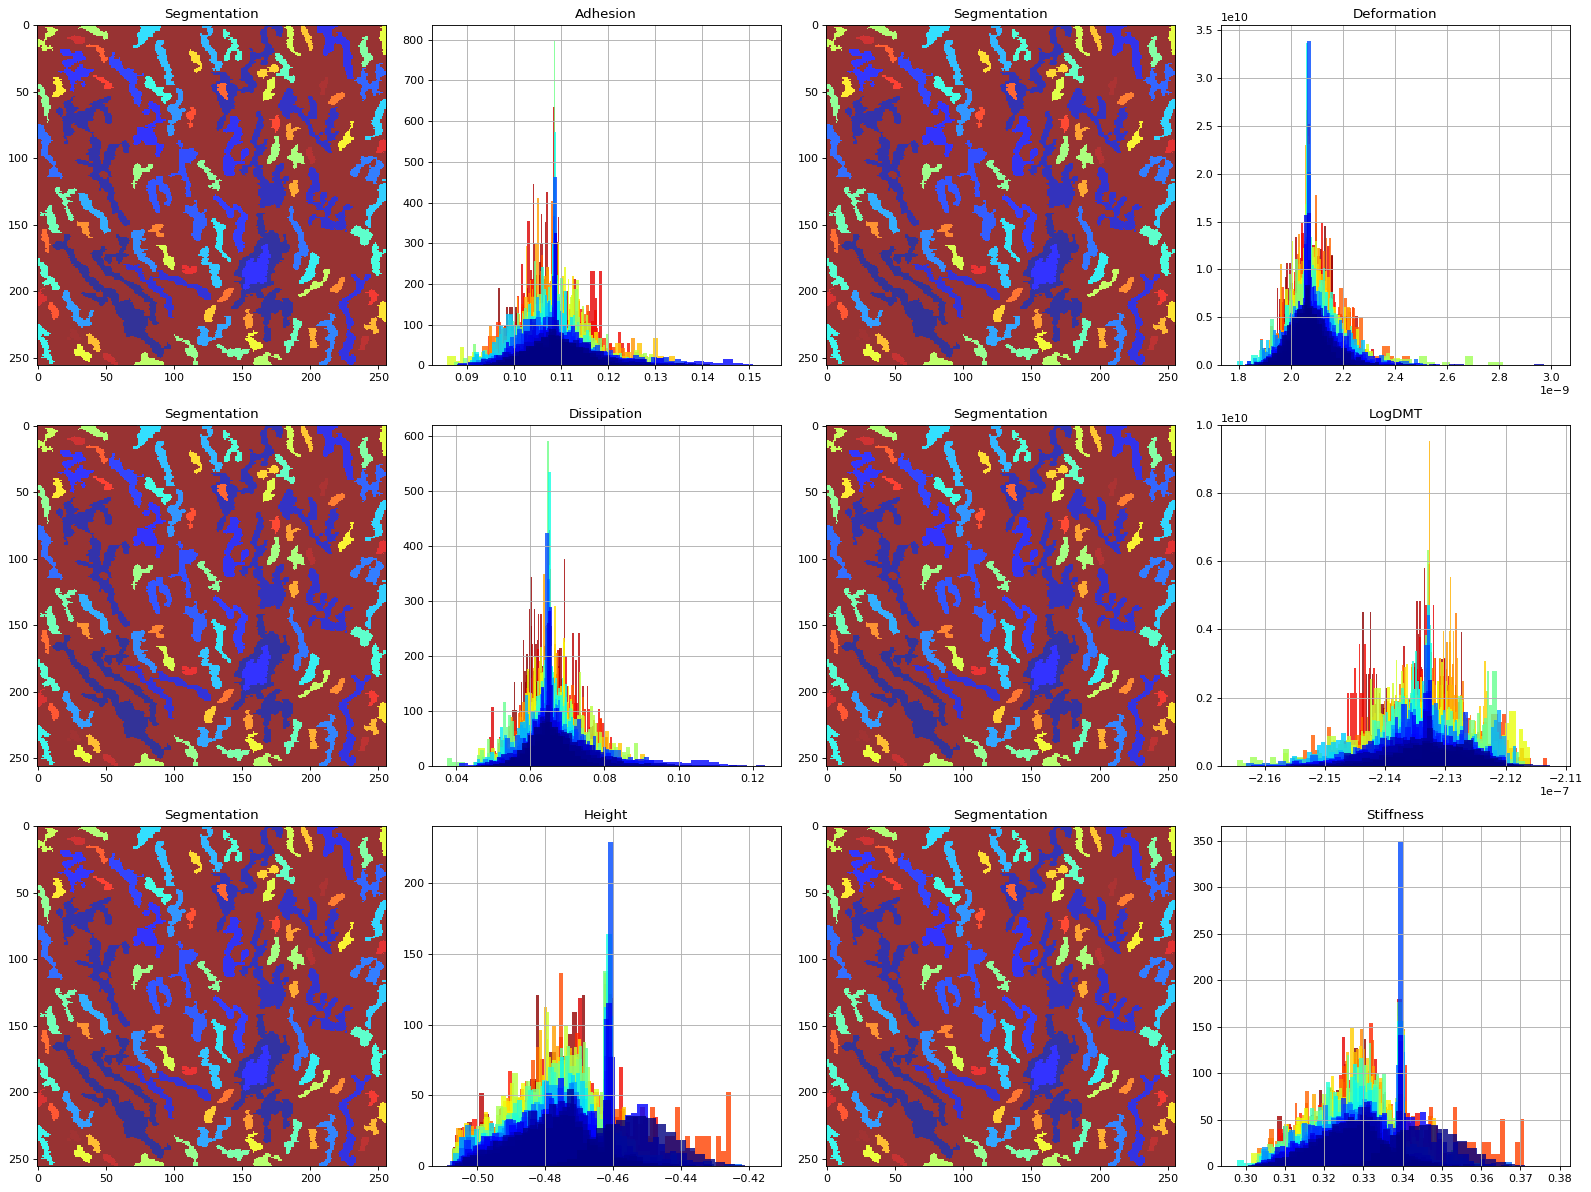

In [25]:
# Distributions of grains after instance segmentation
if remove_outliers_flag:
    post.show_distributions_together(grain_labels, no_outliers_data, data_type, input_cmap=input_cmap)
else:
    post.show_distributions_together(grain_labels, data, data_type, input_cmap=input_cmap)
    

In [79]:
# Apply instance segmentation (persistence watershed)
seg = seg_water.SegmenterWatershed()
height_id = data_properties.index("Height")
height_data = data[:, :, height_id]


thresh = 0.01 # TODO: change to 0.01 for cAMF and AMFM and 0.4 otherwise
if remove_outliers_flag:
    labels = seg.fit_transform(height_data, outliers, pers_thresh=thresh)
else:
    labels = seg.fit_transform(height_data, pers_thresh=thresh)
    

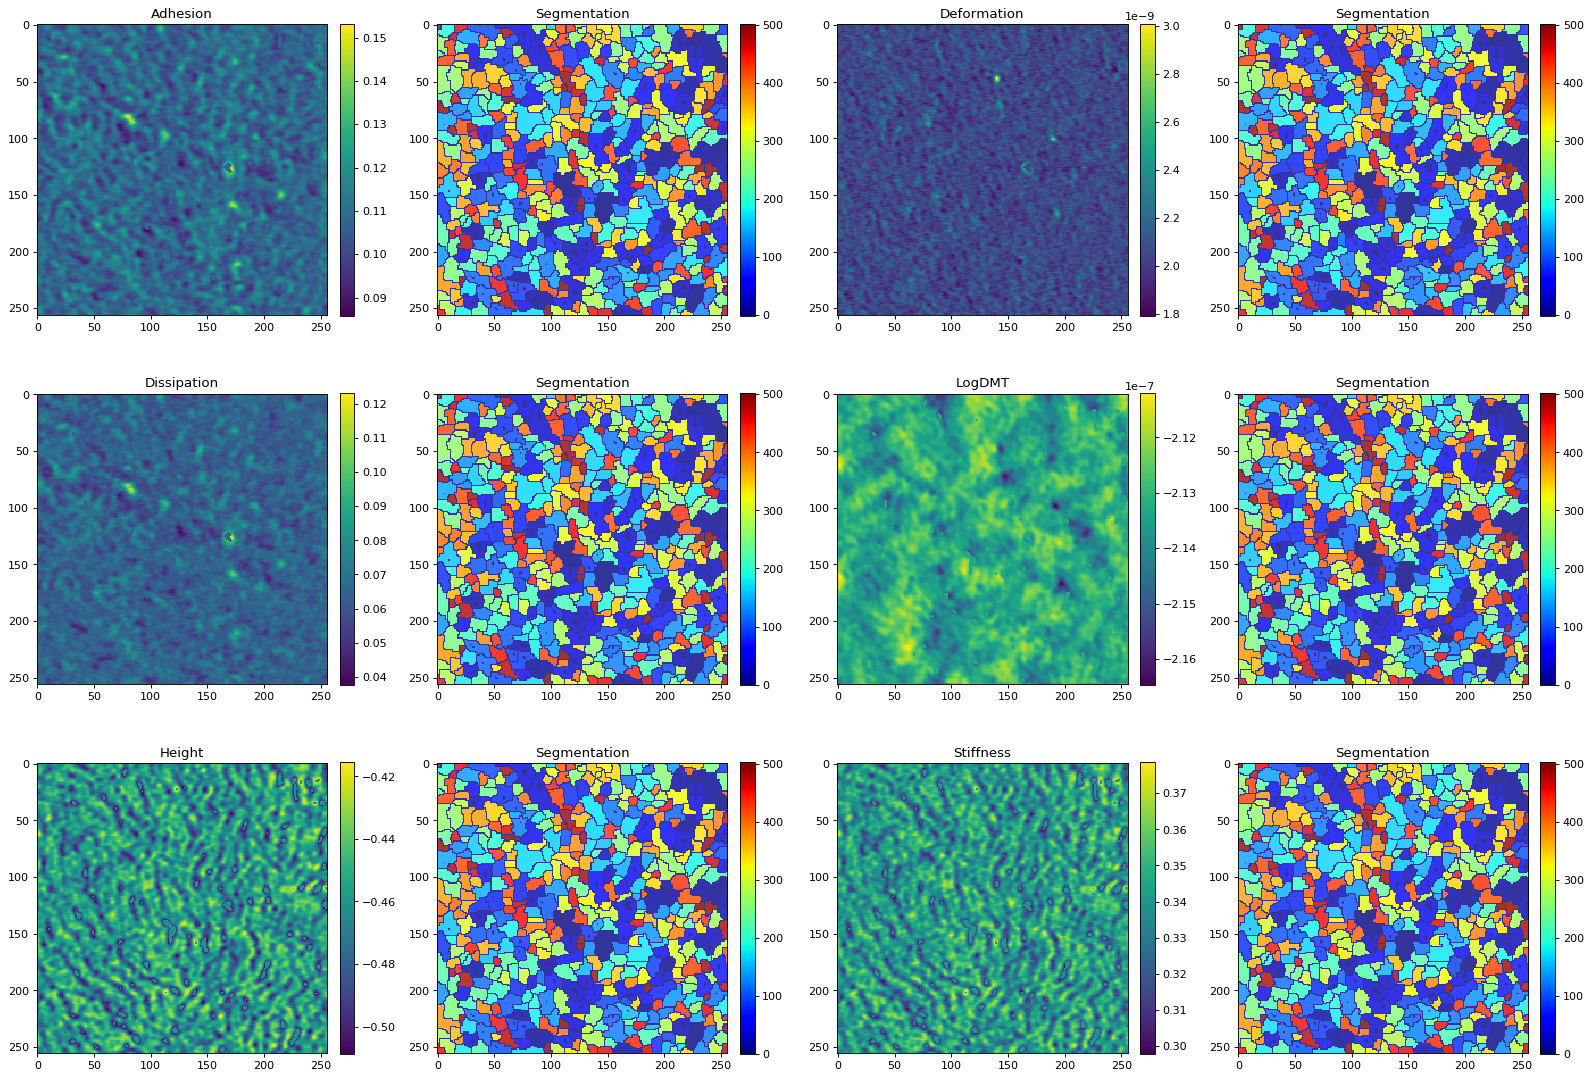

In [80]:
# Instance (grains) segmentation of properties
if remove_outliers_flag:
    post.show_classification(labels, no_outliers_data, data_type)
else:
    post.show_classification(labels, data, data_type)


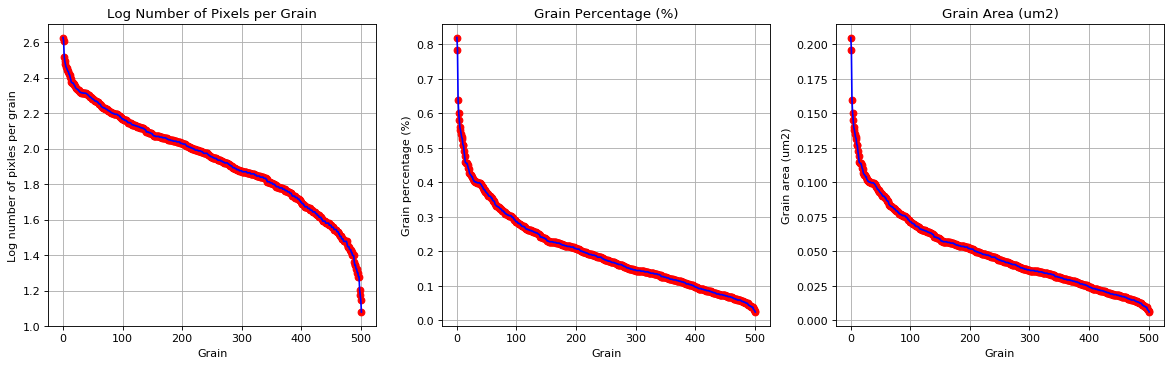

In [28]:
# Show grain area distribution after instance segmentation
post.show_grain_area_distribution(labels, data_type, data_subtype)

In [ ]:
# Distributions of grains after instance segmentation
if remove_outliers_flag:
    post.show_classification_distributions(labels, no_outliers_data, data_type)
else:
    post.show_classification_distributions(labels, data, data_type)
